In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os

## Task 1

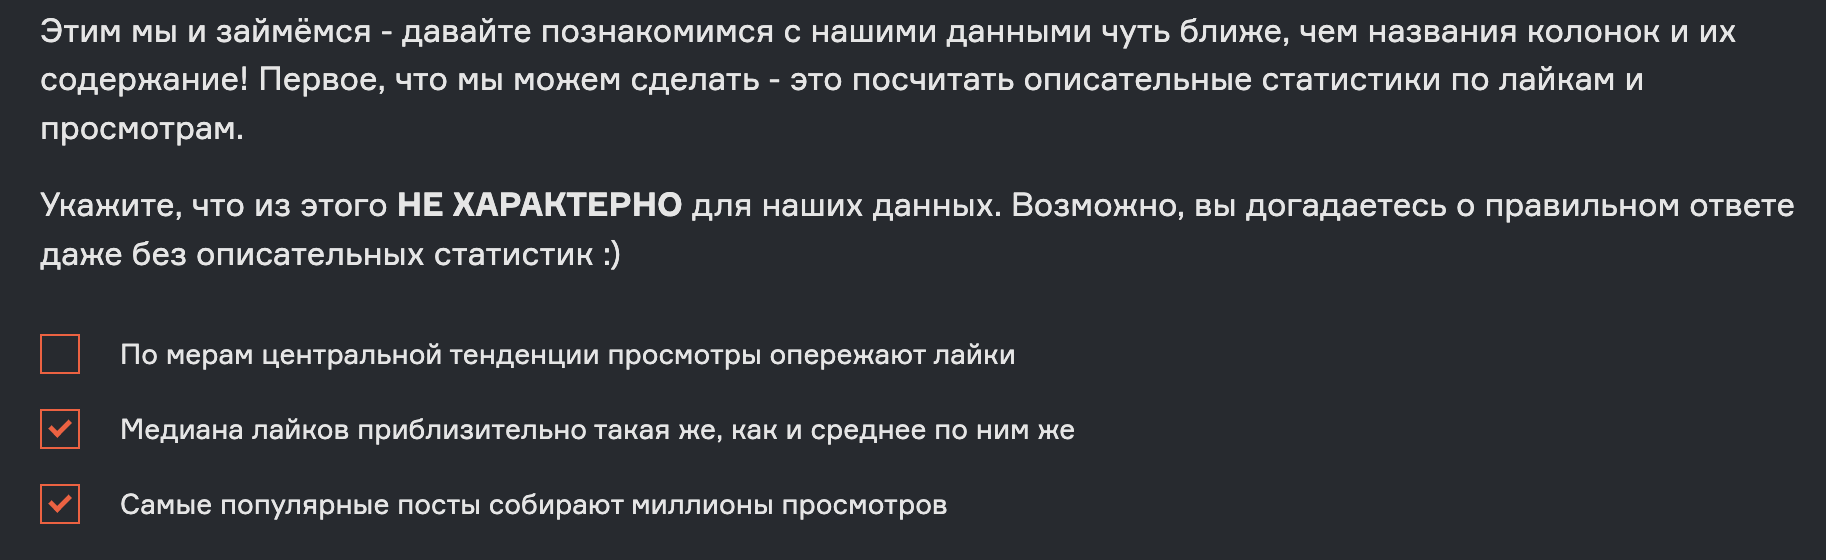

In [2]:
df = Getch(''' select likes, count(user_id) as users
from (
select user_id,
    countIf(user_id, action='like') as likes
from simulator_20211220.feed_actions
group by user_id)
group by likes
order by likes''').df
df

,likes,users
0,0,85
1,1,308
2,2,555
3,3,759
4,4,854
...,...,...
367,416,1
368,424,1
369,432,1
370,447,1


In [10]:
df.users.mean(), df.users.median()

(455.0529595015576, 105.0)

[(0.0, 1799.65)]

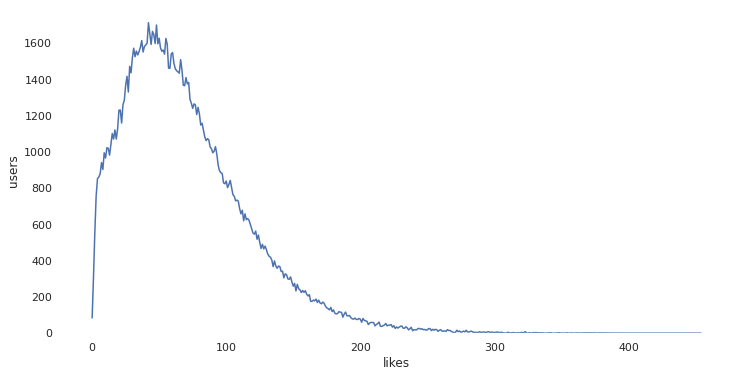

In [5]:
sns.set(rc={'figure.figsize': (12, 6)}) 
plt.tight_layout()

ax = sns.lineplot( 
    x=df['likes'], 
    y=df['users']
    )

ax.set_facecolor('white')
ax.grid(True)

ax.set(ylim=(0, None))

## Task 2

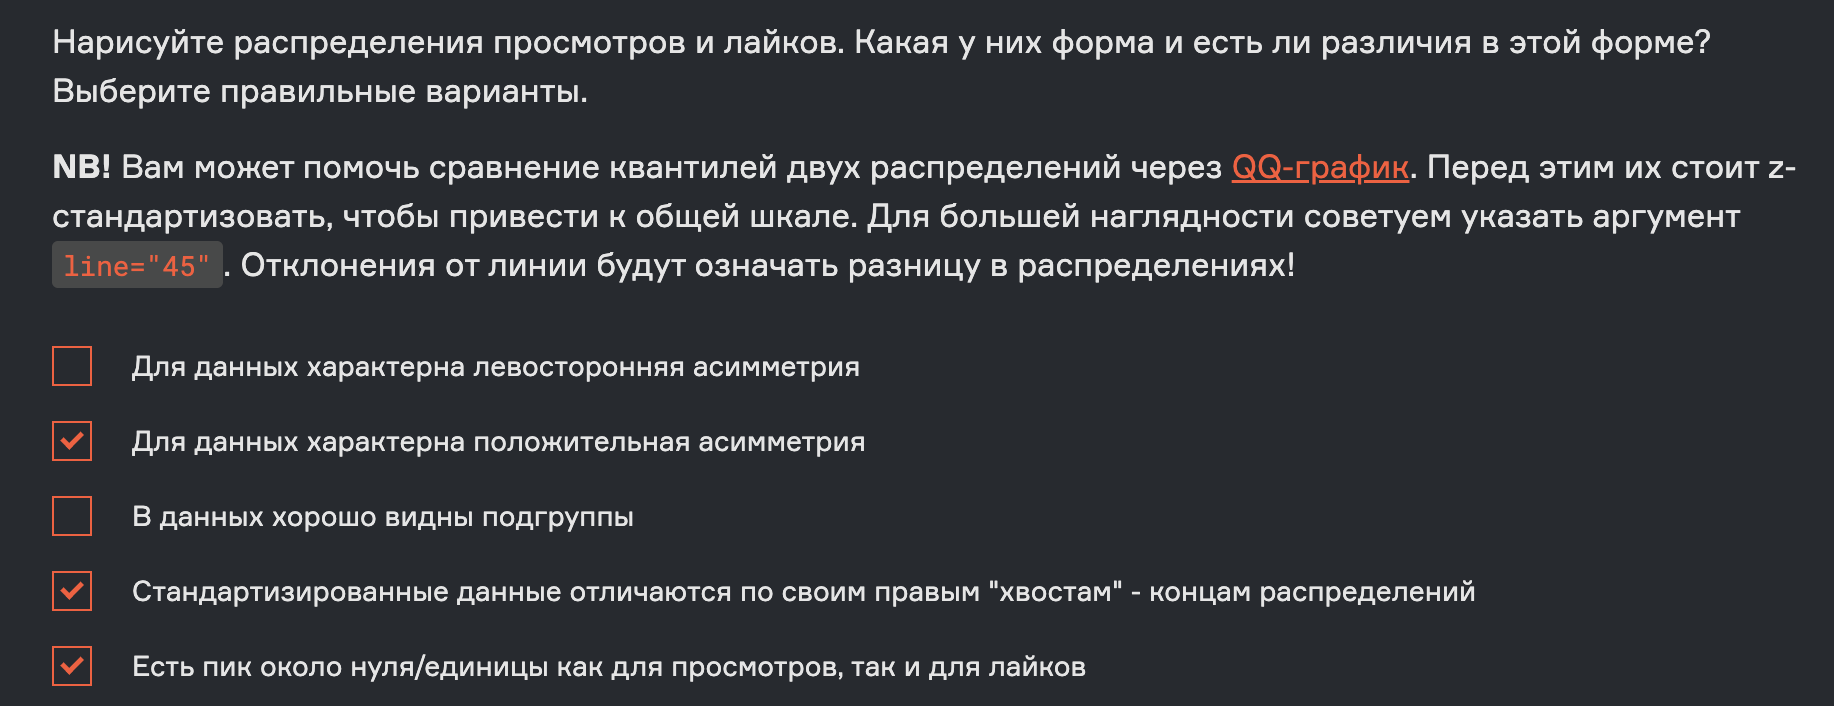

In [3]:
df = Getch('''
select post_id,
    countIf(post_id, action='like') as likes,
    countIf(post_id, action='view') as views
from simulator_20211220.feed_actions
group by post_id''').df
df = df.set_index('post_id')
df

,likes,views
post_id,,
610,2271,10727
4660,192,1637
4742,1,11
720,1089,6120
948,2051,9846
...,...,...
3099,3483,17243
7245,122,1293
3241,934,6011


In [14]:
df.fillna(0).describe().round(2)

,likes,views
count,7023.00,7023.00
mean,1635.60,7738.69
std,3186.98,12092.03
min,0.00,1.00
25%,50.00,553.50
50%,343.00,2775.00
75%,1636.50,9473.50
max,31714.00,104338.00


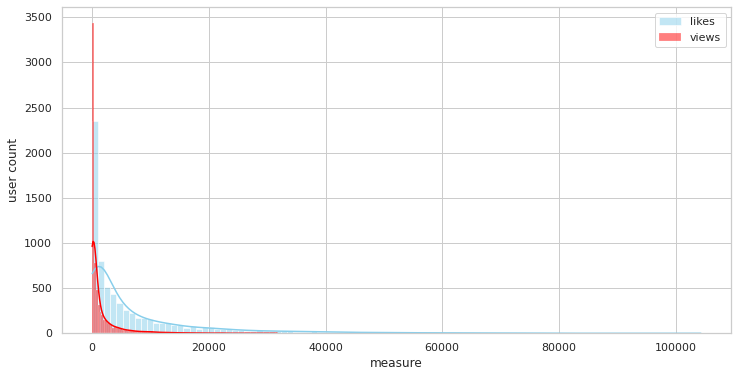

In [16]:
# sns.set(rc={'figure.figsize': (12, 6)}) 
# plt.tight_layout()

sns.set(style="whitegrid", rc={'figure.figsize': (12, 6)})

sns.histplot(x="views", data=df, color="skyblue", label="likes", kde=True, bins=100)
sns.histplot(x="likes", data=df, color="red", label="views", kde=True, bins=100)

plt.xlabel('measure')
plt.ylabel('user count')

plt.legend() 
plt.show()

In [17]:
z_data = df.copy()

z_data["likes"] = (z_data["likes"] - z_data["likes"].mean())/z_data["likes"].std()
z_data["views"] = (z_data["views"] - z_data["views"].mean())/z_data["views"].std()

z_data.head()

,likes,views
post_id,,
610,0.199375,0.247131
4660,-0.452966,-0.504604
4742,-0.512898,-0.639073
720,-0.171509,-0.133864
948,0.130344,0.174273


In [19]:
import warnings
warnings.filterwarnings("ignore")


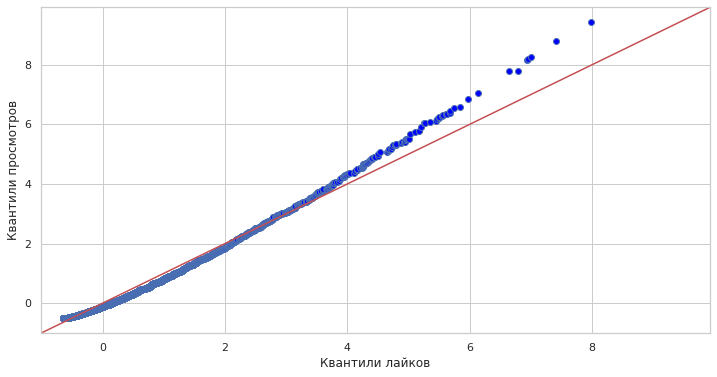

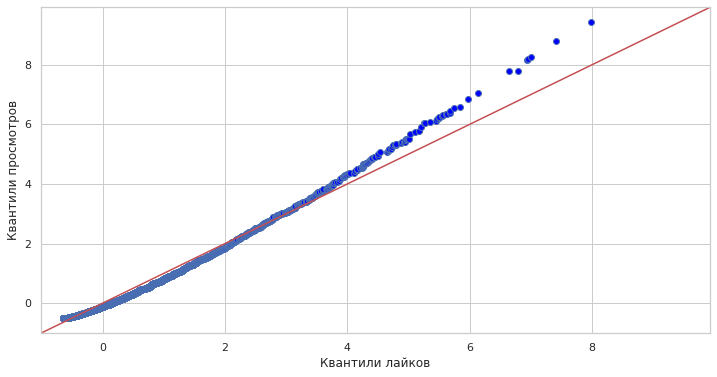

In [21]:
from statsmodels.graphics.gofplots import qqplot_2samples

qqplot_2samples(z_data["likes"], z_data["views"], line="45", 
                xlabel="Квантили лайков", ylabel="Квантили просмотров")

## Task 3

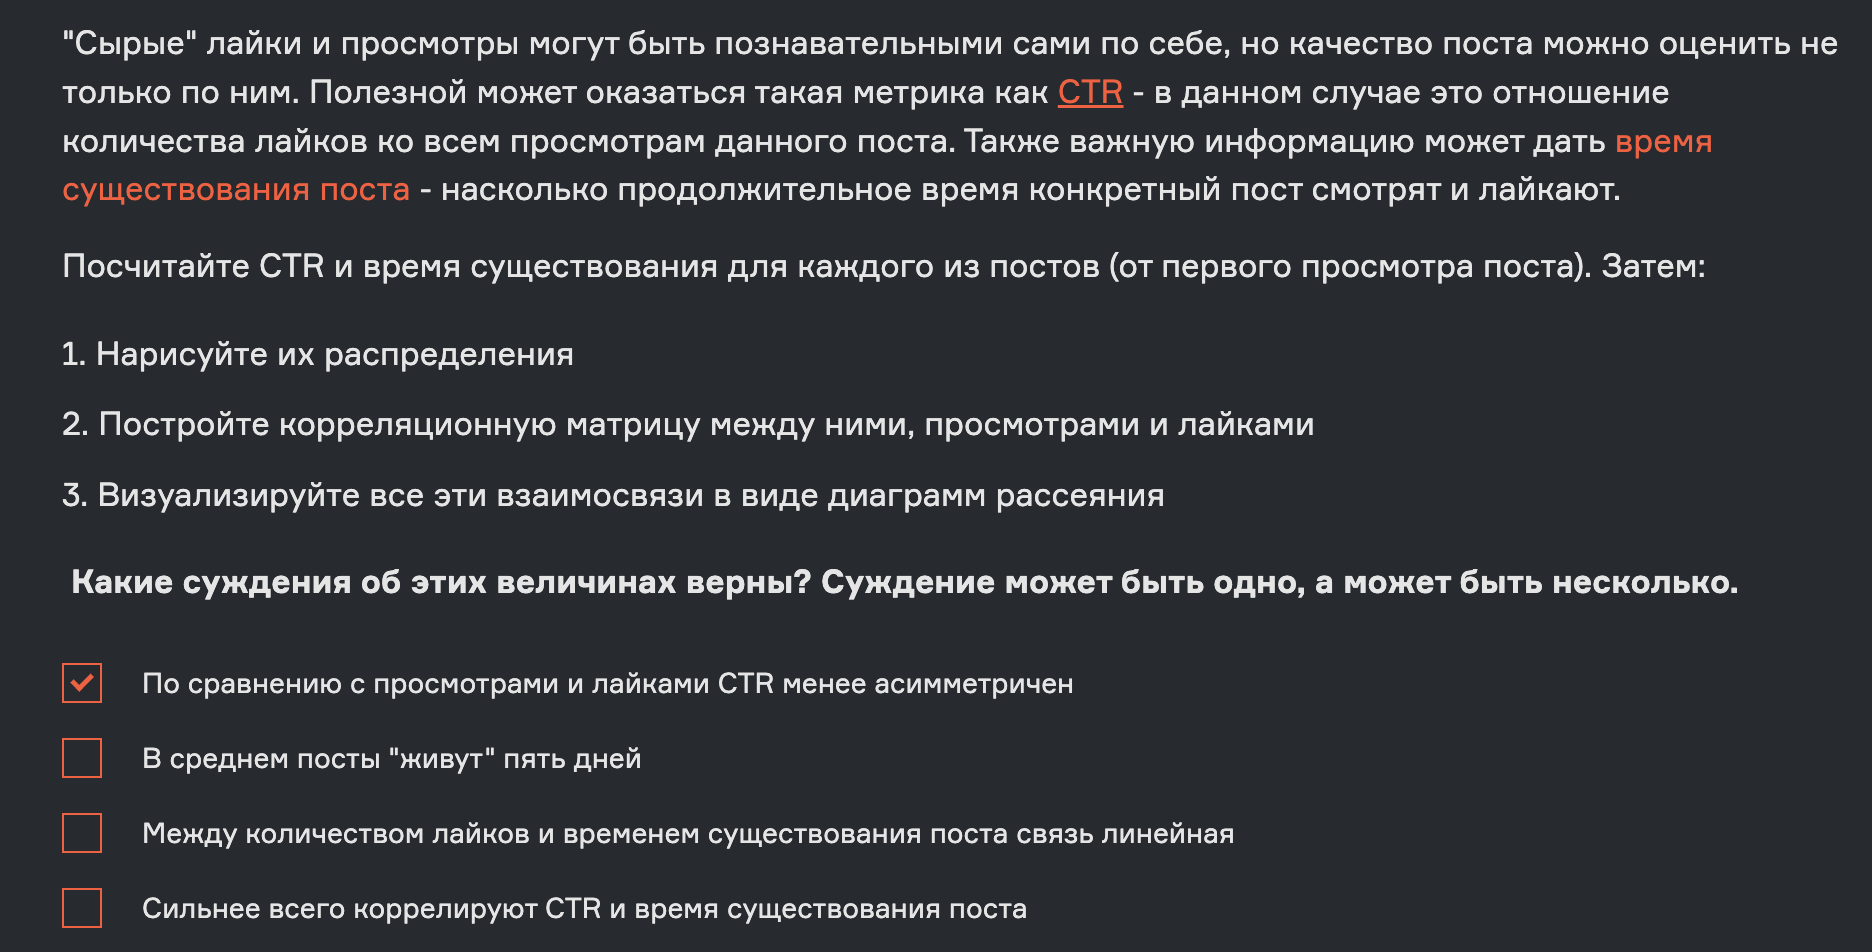

In [20]:
df = Getch('''
select post_id,
    countIf(post_id, action='like') as likes,
    countIf(post_id, action='view') as views,
    countIf(post_id, action='like')/countIf(post_id, action='view') as ctr,
    max(toDate(time)) - min(toDate(time)) as life_d
from simulator_20211220.feed_actions fa
group by post_id''').df
df = df.set_index('post_id')
df

,likes,views,ctr,life_d
post_id,,,,
610,2271,10727,0.211709,4
4660,192,1637,0.117288,1
4742,1,11,0.090909,0
720,1089,6120,0.177941,3
948,2051,9846,0.208308,3
...,...,...,...,...
3099,3483,17243,0.201995,4
7245,122,1293,0.094354,1
3241,934,6011,0.155382,2


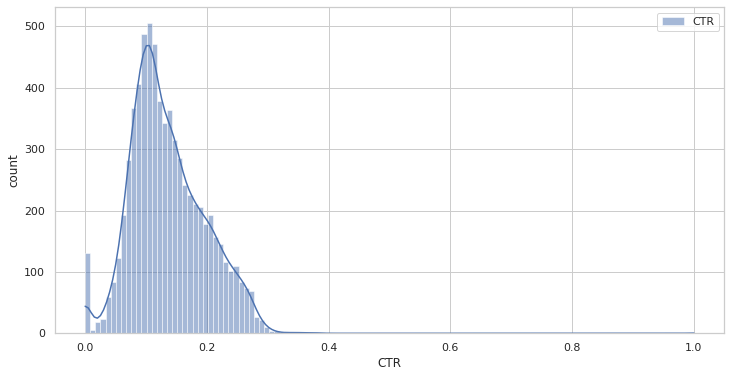

In [21]:
sns.set(rc={'figure.figsize':(12,6)}, style='whitegrid')

sns.histplot(df['ctr'].values, label='CTR', kde=True)

plt.xlabel('CTR')
plt.ylabel('count')

plt.legend()
plt.show()

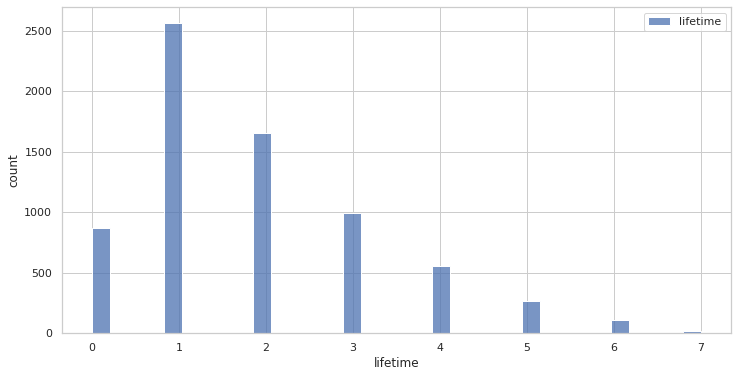

In [22]:
sns.set(rc={'figure.figsize':(12,6)}, style='whitegrid')

sns.histplot(df['life_d'].values, label='lifetime')

plt.xlabel('lifetime')
plt.ylabel('count')

plt.legend()
plt.show()

In [23]:
df.corr()

,likes,views,ctr,life_d
likes,1.000000,0.990007,0.744638,0.795641
views,0.990007,1.000000,0.794920,0.842981
ctr,0.744638,0.794920,1.000000,0.864921
life_d,0.795641,0.842981,0.864921,1.000000


In [29]:
df.corr(method = "kendall")

,likes,views,ctr,life_d
likes,1.000000,0.964355,0.816262,0.801198
views,0.964355,1.000000,0.778989,0.790314
ctr,0.816262,0.778989,1.000000,0.770168
life_d,0.801198,0.790314,0.770168,1.000000


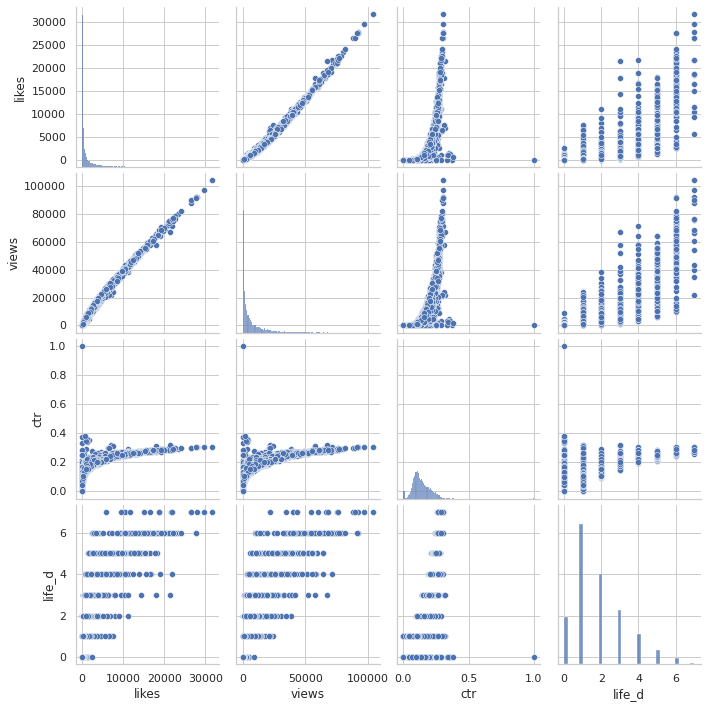

In [30]:
sns.pairplot(df)

## Task 4

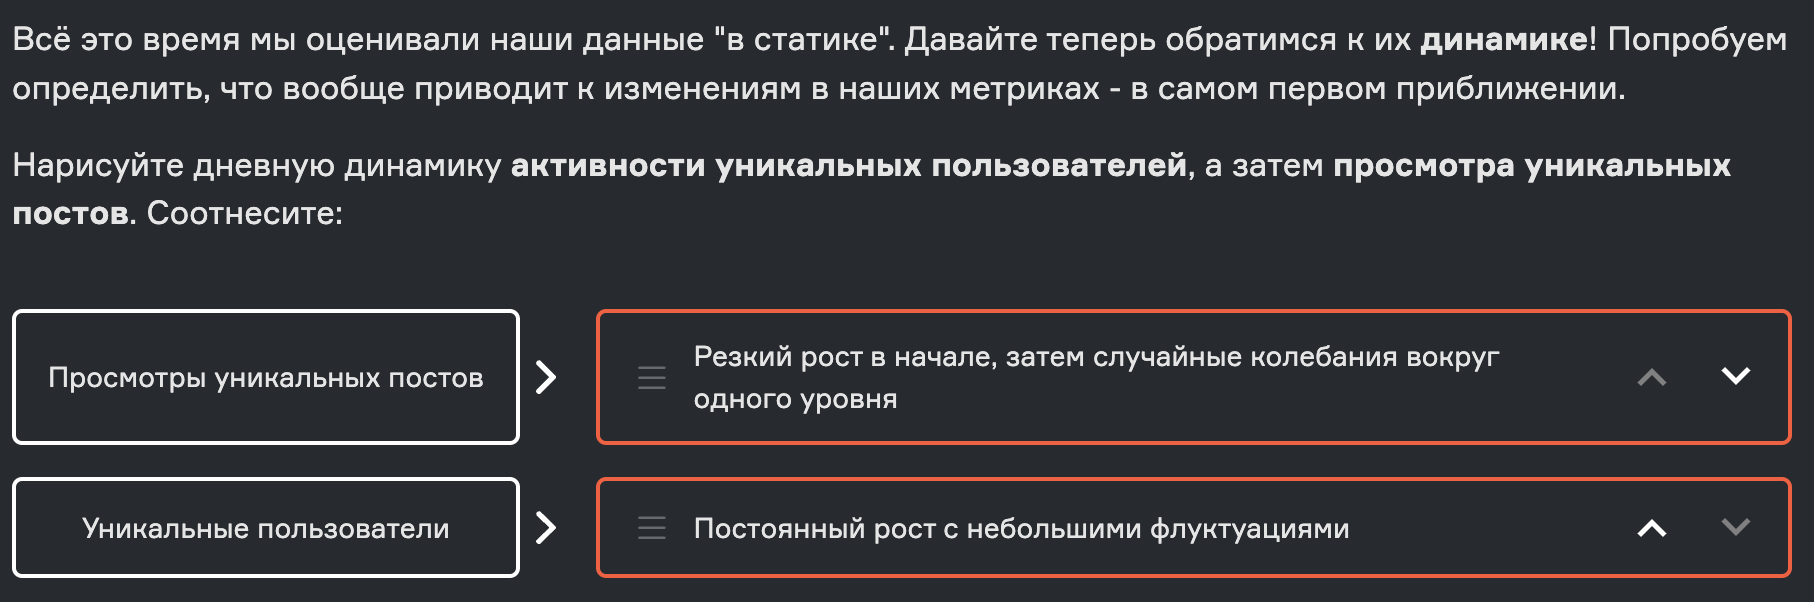

<AxesSubplot:xlabel='day'>

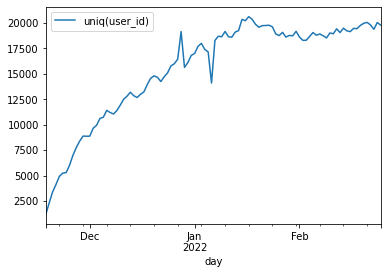

In [4]:
dau = Getch('''
select toDate(time) as day,
    uniq(user_id)
from simulator_20211220.feed_actions fa
group by day''').df

dau.set_index('day').plot()

<AxesSubplot:xlabel='day'>

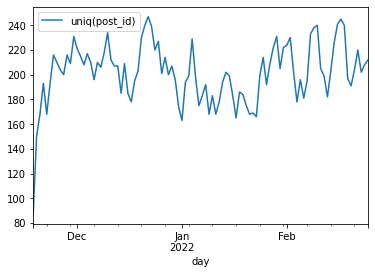

In [5]:
post_un_views = Getch('''
select toDate(time) as day,
    uniq(post_id)
from simulator_20211220.feed_actions fa
group by day''').df

post_un_views.set_index('day').plot()

## Task 5

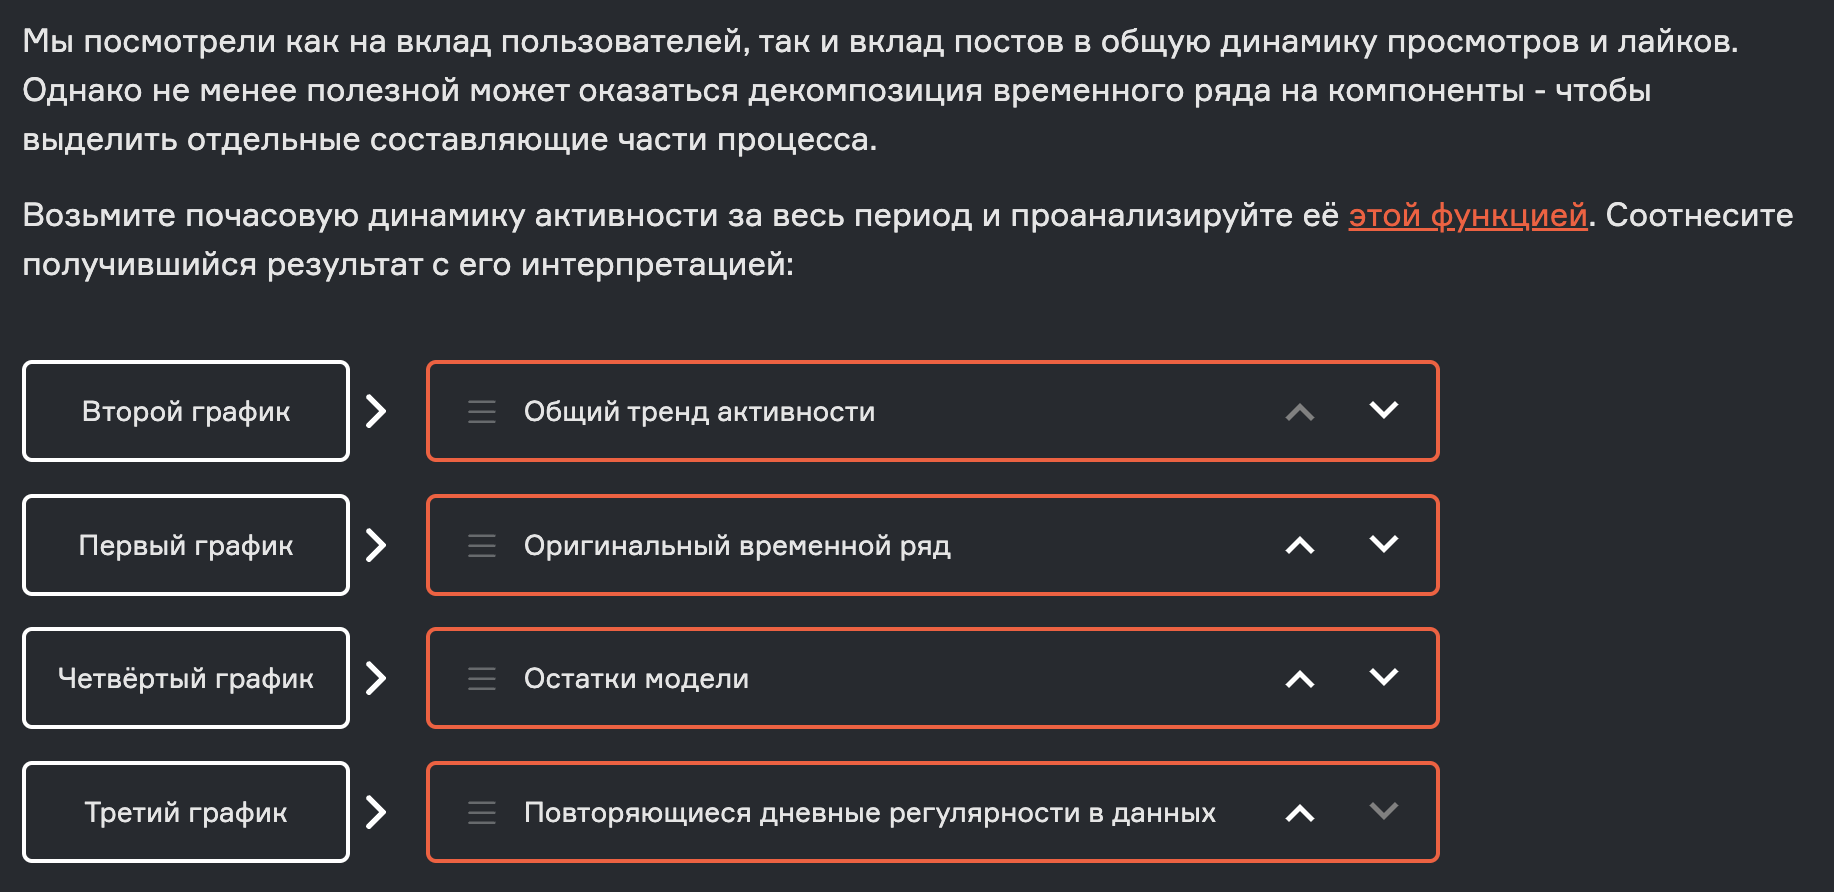

In [23]:
df = Getch('''select toStartOfHour(time) as dt_hour,
count(user_id) as event_cnt
from simulator_20211220.feed_actions
group by dt_hour''').df

df = df.sort_values(by='dt_hour').set_index('dt_hour')
df.head()

,event_cnt
dt_hour,
2021-11-18 00:00:00,61
2021-11-18 01:00:00,65
2021-11-18 02:00:00,45
2021-11-18 03:00:00,30
2021-11-18 04:00:00,38


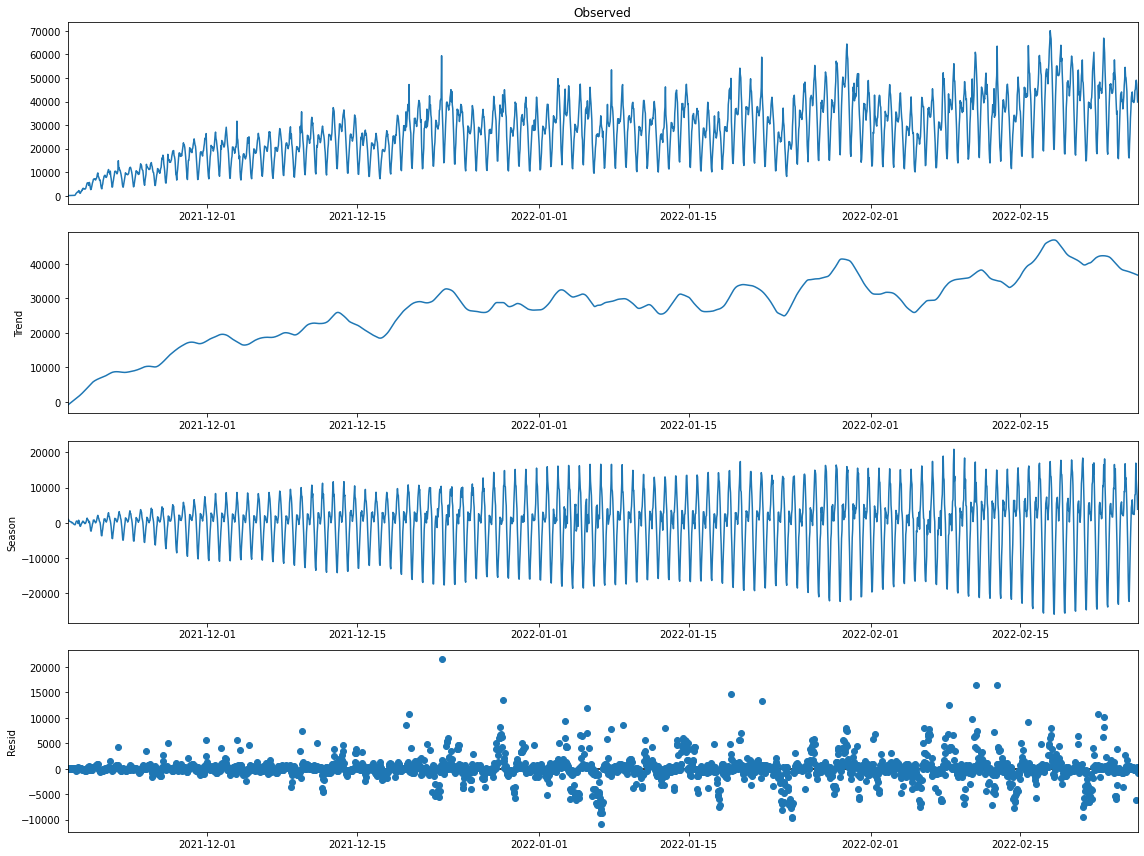

In [34]:
from statsmodels.tsa.seasonal import STL

plt.rc('figure', figsize=(16, 12))
res = STL(df, robust=True).fit()
res.plot()
plt.show()

In [18]:
# df.isnull().sum() - проверка на количество null в датасете

dt_hour      0
event_cnt    0
dtype: int64

## Task 6

In [8]:
events_h = Getch('''select toHour(toStartOfHour(time)) as hour,
count(user_id) as event_cnt
from simulator_20211220.feed_actions
group by hour''').df
events_h

,hour,event_cnt
0,0,2579431
1,1,2161911
2,2,1602505
3,3,1177348
4,4,1120440
5,5,1576540
6,6,1944377
7,7,2387124
8,8,2647259
9,9,3061272


In [7]:
posts_h = Getch('''
select hour,
count(post_id) as post_cnt
from (select 
post_id,
toHour(min(toStartOfHour(time))) as hour
from simulator_20211220.feed_actions
group by post_id)
group by hour''').df

posts_h

,hour,post_cnt
0,0,218
1,1,74
2,2,12
3,9,1
4,10,5
5,11,13
6,12,26
7,13,83
8,14,194
9,15,284


[(0.0, 4190762.1)]

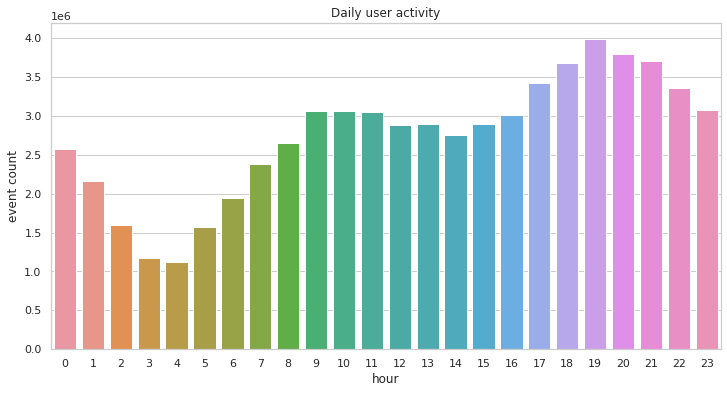

In [11]:
sns.set(rc={'figure.figsize': (12, 6)}, style='whitegrid') 
plt.tight_layout()

ax = sns.barplot( 
    x=events_h['hour'], 
    y=events_h['event_cnt']
    )

ax.set(xlabel='hour')
ax.set(ylabel='event count') 

ax.set_title('Daily user activity') 
ax.set(ylim=(0, None))

[(0.0, 1087.8)]

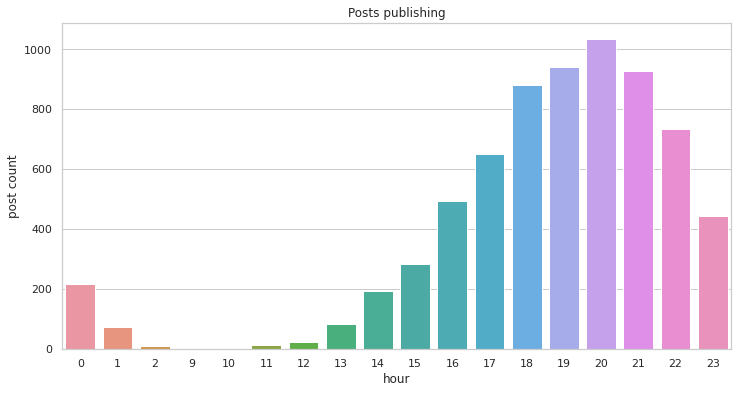

In [12]:
sns.set(rc={'figure.figsize': (12, 6)}, style='whitegrid') 
plt.tight_layout()

ax = sns.barplot( 
    x=posts_h['hour'], 
    y=posts_h['post_cnt']
    )

ax.set(xlabel='hour')
ax.set(ylabel='post count') 

ax.set_title('Posts publishing') 
ax.set(ylim=(0, None))